El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

In [33]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
import xgboost as xgb
import time
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix



## Preparación de datos

In [3]:
#Preparing data 

data_car = pd.read_csv('car_data.csv')

In [4]:
data_car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data_car.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17
5,04/04/2016 17:36,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,04/04/2016 00:00,0,33775,06/04/2016 19:17
6,01/04/2016 20:48,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,01/04/2016 00:00,0,67112,05/04/2016 18:18
7,21/03/2016 18:54,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,21/03/2016 00:00,0,19348,25/03/2016 16:47
8,04/04/2016 23:42,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,04/04/2016 00:00,0,94505,04/04/2016 23:42
9,17/03/2016 10:53,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,17/03/2016 00:00,0,27472,31/03/2016 17:17


In [6]:
data_car.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [7]:
data_car.columns = data_car.columns.str.lower()

data_car['vehicletype'] = data_car['vehicletype'].fillna('unknown')
data_car['gearbox'] = data_car['gearbox'].fillna('unknown')
data_car['model'] = data_car['model'].fillna('unknown')
data_car['fueltype'] = data_car['fueltype'].fillna('unknown')
data_car['notrepaired'] = data_car['notrepaired'].fillna('unknown')

In [8]:
data_car

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,24/03/2016 11:52,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,21/03/2016 09:50,0,unknown,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,21/03/2016 00:00,0,2694,21/03/2016 10:42
354365,14/03/2016 17:48,2200,unknown,2005,unknown,0,unknown,20000,1,unknown,sonstige_autos,unknown,14/03/2016 00:00,0,39576,06/04/2016 00:46
354366,05/03/2016 19:56,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,05/03/2016 00:00,0,26135,11/03/2016 18:17
354367,19/03/2016 18:57,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,19/03/2016 00:00,0,87439,07/04/2016 07:15


In [48]:
data_car.describe()

,price,registrationyear,power,mileage,registrationmonth,numberofpictures,postalcode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


## Conclusiones.
Los datos se encontraban con mucho ruido, tenian datos desconocidos que pueden afectar la precision en la predicción.
Para los datos categoricos la mejor opción fue agregarlos como (unknown) esto porque cuando hagamos en encoder OHE se podrán ocupar.


## Entrenamiento del modelo 

In [49]:
# Drop data not important to train our model
model_data = data_car.drop(columns=['datecrawled','datecreated','numberofpictures','postalcode','lastseen','price'],axis=1)

Se eliminan los datos que no son relevantes con el target

In [10]:
outliers_features = [['registrationyear','power','mileage','registrationmonth']]
lower_percentile = 0.01
upper_percentile = 0.99


# Filter avery column 
for column in outliers_features:
    
    lower_bound = model_data[column].quantile(lower_percentile)
    upper_bound = model_data[column].quantile(upper_percentile)
    filtered_df = model_data[(model_data[column] >= lower_bound) & (model_data[column] <= upper_bound)]

# Create df filtered
filtered_df['power'] = filtered_df['power'].fillna(filtered_df['power'].mean())
filtered_df['registrationyear'] = filtered_df['registrationyear'].fillna(filtered_df['registrationyear'].mean())
filtered_df.describe()

,registrationyear,power,mileage,registrationmonth
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,2003.421911,104.339567,128211.172535,5.714645
std,6.576751,59.044857,37905.341530,3.726421
min,1980.000000,0.000000,5000.000000,0.000000
25%,1999.000000,69.000000,125000.000000,3.000000
50%,2003.000000,104.339567,150000.000000,6.000000
75%,2008.000000,140.000000,150000.000000,9.000000
max,2018.000000,300.000000,150000.000000,12.000000


Tomé tu recomendación para filtrar por porcentiles a los datos que tenian outliers y que generaban ruido. Los datos que generaron ruido fueron cambiados por el promedio para conservar la mayor cantidad de datos y que puedan mejorar el modelo.

In [11]:
categorical_features  = ['vehicletype','gearbox','fueltype','notrepaired','model','brand']
number_features = ['registrationyear','power','mileage','registrationmonth']
    
enc = OneHotEncoder(sparse_output=False)
enc.fit(model_data[categorical_features])
X_train_encoded = enc.transform(model_data[categorical_features])
ohe_df = pd.DataFrame(X_train_encoded, columns=enc.get_feature_names_out(categorical_features))
    
    
#
scaler = StandardScaler()
scaled_data = scaler.fit_transform(filtered_df[number_features])
scaler_df = pd.DataFrame(scaled_data,columns=number_features)
    

df_prepocessing = pd.concat([scaler_df, ohe_df,data_car['price']], axis=1) 

In [12]:
X = df_prepocessing.drop(columns='price',axis=1)
y = df_prepocessing['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
start_time = time.time()

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print(f"Linear Regression RMSE: {rmse_lr}")
print(f"Execution Time: {time.time() - start_time} seconds")

Linear Regression RMSE: 2711.423873130651
Execution Time: 20.75261902809143 seconds


In [13]:
X = df_prepocessing.drop(columns='price',axis=1)
y = df_prepocessing['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

start_time = time.time()
tree = DecisionTreeRegressor(random_state=42)
param_grid_tree = {'max_depth': [5, 10, 15, 20]}
grid_tree = GridSearchCV(tree, param_grid_tree, cv=3, scoring='neg_mean_squared_error')
grid_tree.fit(X_train, y_train)
best_tree = grid_tree.best_estimator_
y_pred_tree = best_tree.predict(X_test)
rmse_tree = np.sqrt(mean_squared_error(y_test, y_pred_tree))
print(f"Decision Tree RMSE: {rmse_tree}")
print(f"Execution Time: {time.time() - start_time} seconds")

Decision Tree RMSE: 2079.5406256211077
Execution Time: 82.04346990585327 seconds


In [14]:
X = df_prepocessing.drop(columns='price',axis=1)
y = df_prepocessing['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

start_time = time.time()
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

params_lgb = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbosity': -1  # Controla el nivel de salida (-1 silencia todas las salidas)
}

model_lgb = lgb.train(
    params_lgb,
    lgb_train,
    num_boost_round=100,
    valid_sets=[lgb_test]
)
y_pred_lgb = model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
print(f"LightGBM RMSE: {rmse_lgb}")
print(f"Execution Time: {time.time() - start_time} seconds")

LightGBM RMSE: 1872.3209732489715
Execution Time: 4.660163402557373 seconds


In [15]:
X = df_prepocessing.drop(columns='price',axis=1)
y = df_prepocessing['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

start_time = time.time()
cat_model = CatBoostRegressor(iterations=100, depth=10, learning_rate=0.1, random_seed=42, verbose=0)
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=10)
y_pred_cat = cat_model.predict(X_test)
rmse_cat = np.sqrt(mean_squared_error(y_test, y_pred_cat))
print(f"CatBoost RMSE: {rmse_cat}")
print(f"Execution Time: {time.time() - start_time} seconds")

CatBoost RMSE: 1894.4809501644597
Execution Time: 9.464245557785034 seconds


In [30]:
X = df_prepocessing.drop(columns='price',axis=1)
y = df_prepocessing['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

start_time = time.time()
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"XGBoost RMSE: {rmse_xgb}")
print(f"Execution Time: {time.time() - start_time} seconds")

XGBoost RMSE: 1760.3389703995404
Execution Time: 12.3434898853302 seconds


## Análisis del modelo

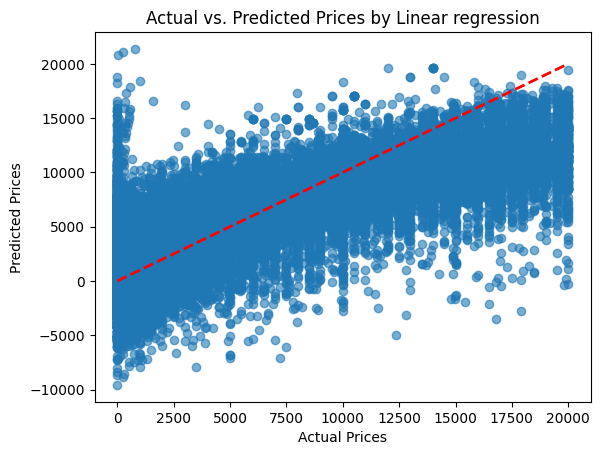

In [43]:
plt.scatter(y_test, y_pred_lr, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted Prices by Linear regression")
plt.show()

El modelo por regresión lineal tuvo problemas para para predecir los precios tanto en los precios más bajos como en los caros hay una gran dispersion y con valores negativos lo cual lo convierte como el modelo menos efectivo para usarse

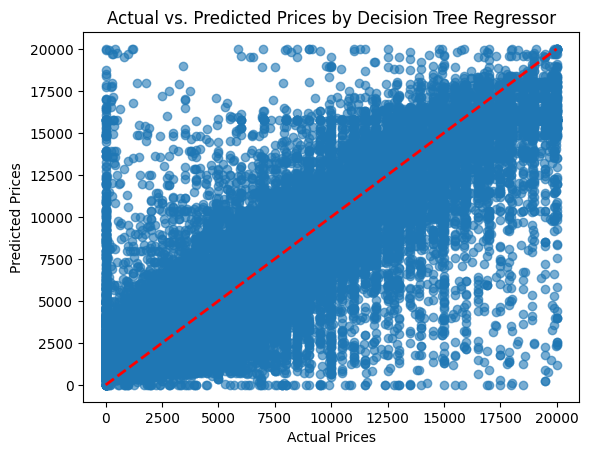

In [44]:
plt.scatter(y_test, y_pred_tree, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted Prices by Decision Tree Regressor")
plt.show()

Hay algunos puntos cercanos a la línea roja, la dispersión es notable, especialmente para precios intermedios (entre 5,000 y 15,000).
Esto indica que el modelo no está generalizando bien en toda la gama de valores de precios.
Agrupación en regiones específicas:

Observamos una agrupación vertical de puntos, lo que es característico de un Decision Tree Regressor. Este modelo tiende a predecir valores constantes dentro de ciertos rangos de datos.
Valores extremos:

El modelo parece tener problemas con valores altos, ya que la dispersión en la parte superior derecha del gráfico es mayor.
Menor precisión para precios medios:

A diferencia de los precios bajos, donde el modelo parece más confiable, los valores intermedios muestran una mayor dispersión y errores más notables.

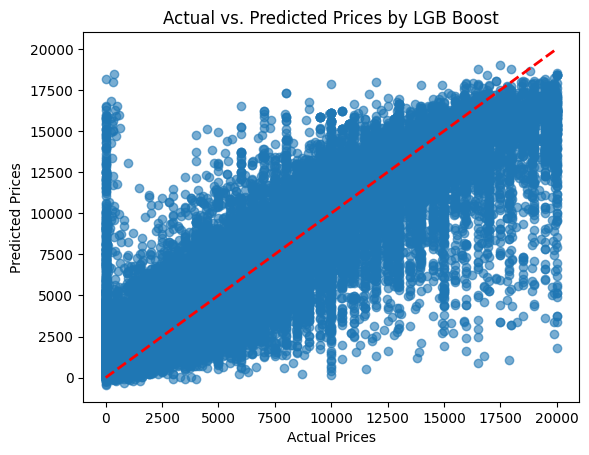

In [46]:
plt.scatter(y_test, y_pred_lgb, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted Prices by LGB Boost")
plt.show()

Hay una mejoria considerable, especialmente en los volores donde podemos encontrar una menor disperción con respecto al modelo anterior. En los valores más grandes le cuesta ligeramente en especial en los mayores a los de 10,000.

Todo lo contrario en los valores más bajos donde es más preciso y cercano a los valores reales.

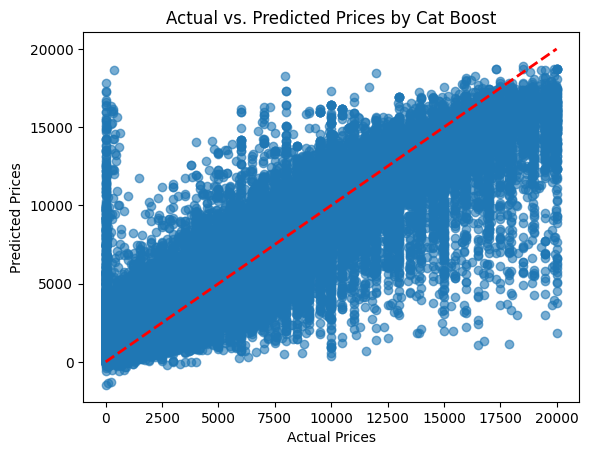

In [45]:
plt.scatter(y_test, y_pred_cat, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted Prices by Cat Boost")
plt.show()

Una menor disperción en los valores más altos.
Los valores intermedios se encuentran más agrupados 

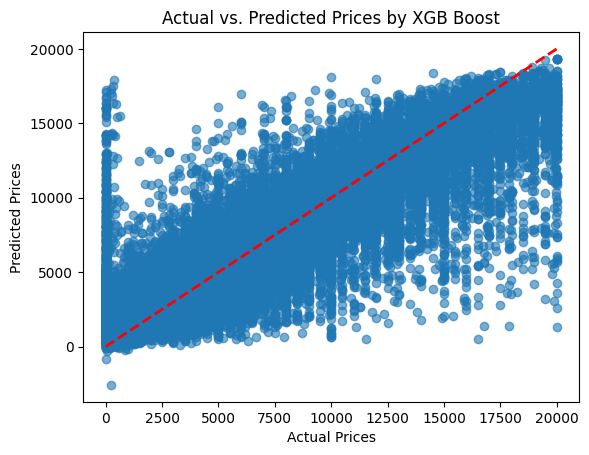

In [47]:
plt.scatter(y_test, y_pred_xgb, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted Prices by XGB Boost")
plt.show()

Hay una alineación más consistente de los puntos alrededor de la línea roja en comparación con los gráficos anteriores, lo que sugiere que este modelo predice precios con mayor precisión.

# Lista de control

Escribe 'x' para verificar. Luego presiona Shift+Enter

- [x]  Jupyter Notebook está abierto
- [ ]  El código no tiene errores- [ ]  Las celdas con el código han sido colocadas en orden de ejecución- [ ]  Los datos han sido descargados y preparados- [ ]  Los modelos han sido entrenados
- [ ]  Se realizó el análisis de velocidad y calidad de los modelos